In [1]:
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
import sklearn
from sklearn import linear_model
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')

In [3]:
def bayes_cov_col(Y,X,cols,lm):
    """
    @Y    = Expression matrix, cells x x genes, expecting pandas dataframe
    @X    = Covariate matrix, cells x covariates, expecting pandas dataframe
    @cols = The subset of columns that the EM should be performed over, expecting list
    @lm   = linear model object
    """

    #EM iterateit
    Yhat=pd.DataFrame(lm.predict(X))
    Yhat.index=Y.index
    Yhat.columns=Y.columns
    SSE_all=np.square(Y.subtract(Yhat))
    X_adjust=X.copy()


    df_SSE   = []
    df_logit = []

    for curcov in cols:

        curcells=X[X[curcov]>0].index

        if len(curcells)>2:

            X_notcur=X.copy()
            X_notcur[curcov]=[0]*len(X_notcur)

            X_sub=X_notcur.loc[curcells]

            Y_sub=Y.loc[curcells]

            GENE_var=2.0*Y_sub.var(axis=0)
            vargenes=GENE_var[GENE_var>0].index

            Yhat_notcur=pd.DataFrame(lm.predict(X_sub))
            Yhat_notcur.index=Y_sub.index
            Yhat_notcur.columns=Y_sub.columns

            SSE_notcur=np.square(Y_sub.subtract(Yhat_notcur))
            SSE=SSE_all.loc[curcells].subtract(SSE_notcur)
            SSE_sum=SSE.sum(axis=1)

            SSE_transform=SSE.div(GENE_var+0.5)[vargenes].sum(axis=1)
            logitify=np.divide(1.0,1.0+np.exp(SSE_transform))#sum))

            df_SSE.append(SSE_sum)
            df_logit.append(logitify)

            X_adjust[curcov].loc[curcells]=logitify

    return X_adjust

In [64]:
#simulate two multivariate normal distributions for two classes
ncells=1000
ngenes=200
halfcells=int(ncells/2.0)
tenthcells=int(ncells/10.0)
informativegenes=0.1
effectsize=1.0

y1=pd.DataFrame(np.random.normal(loc=0,scale=1,size=(halfcells,int(informativegenes*ngenes))))
y2=pd.DataFrame(np.random.normal(loc=effectsize,scale=1,size=(halfcells,int(informativegenes*ngenes))))
#noisy genes
y3=pd.DataFrame(np.random.normal(loc=0,scale=1,size=(ncells,int(ngenes*(1.0-informativegenes)))))
#cells x genes expression matrix
Y=pd.concat([y1,y2]).reset_index(drop=True)
Y=pd.concat([Y,y3],axis=1)
Y.columns=range(np.shape(Y)[1])
Y.head()

X=pd.DataFrame()
classvec=[0]*halfcells
classvec.extend([1]*halfcells)
X['class']=classvec

X_noise=X.copy()
X_noise.ix[0:tenthcells]=1

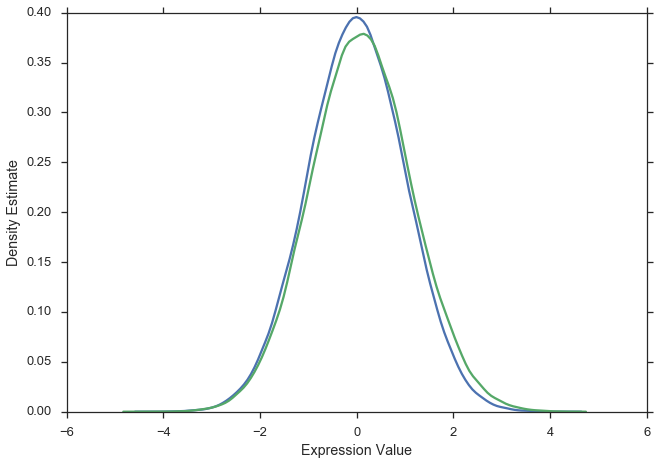

In [65]:
#Kernel Density estimates of the two overlapping distributions
sns.kdeplot(Y.ix[range(halfcells),:].values.flatten())
sns.kdeplot(Y.ix[halfcells+1:,:].values.flatten())
plt.xlabel('Expression Value')
plt.ylabel('Density Estimate')

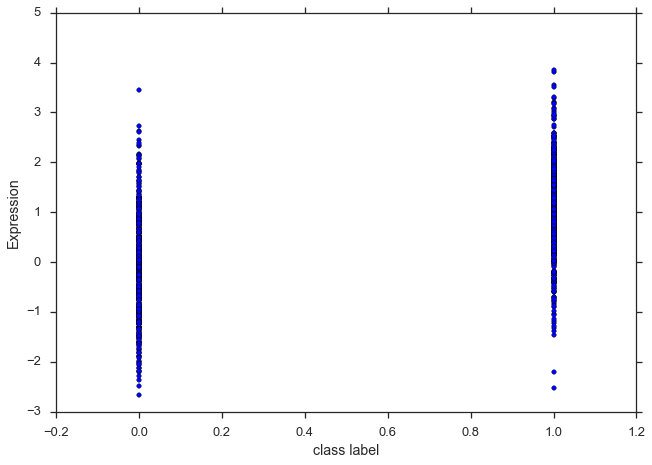

In [66]:
#for a single gene
plt.scatter(X['class'],Y[0])
plt.xlabel('class label')
plt.ylabel('Expression')

In [ ]:
#Fit regression model
lm=sklearn.linear_model.Ridge()
lm.fit(X,Y)
B=pd.DataFrame(lm.coef_)

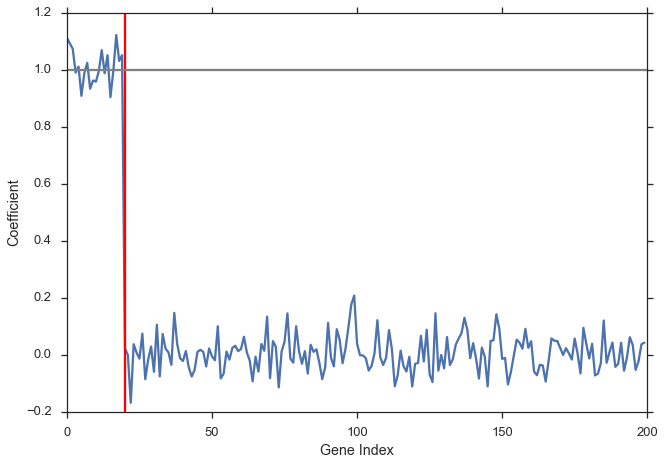

In [74]:
#coefficients for informative subset of genes
plt.plot(B[0])
plt.axvline(ngenes*informativegenes,c='red')
plt.axhline(effectsize,c='gray')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient')

In [75]:
X_adjust=bayes_cov_col(Y,X,['class'],lm)

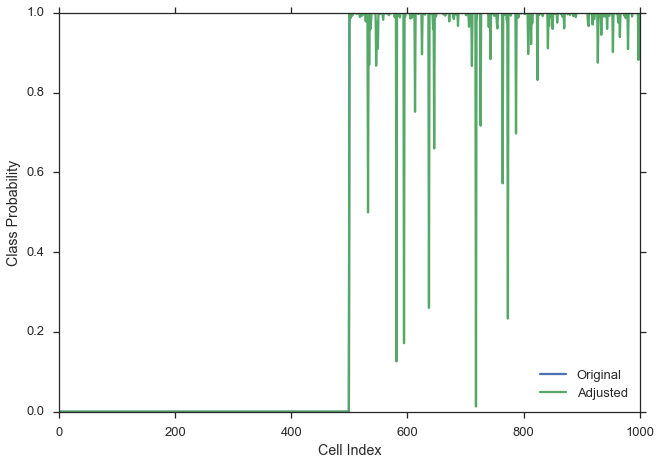

In [76]:
plt.plot(X,label='Original')
plt.plot(X_adjust,label='Adjusted')
plt.legend(loc='lower right')
plt.xlabel('Cell Index')
plt.ylabel('Class Probability')

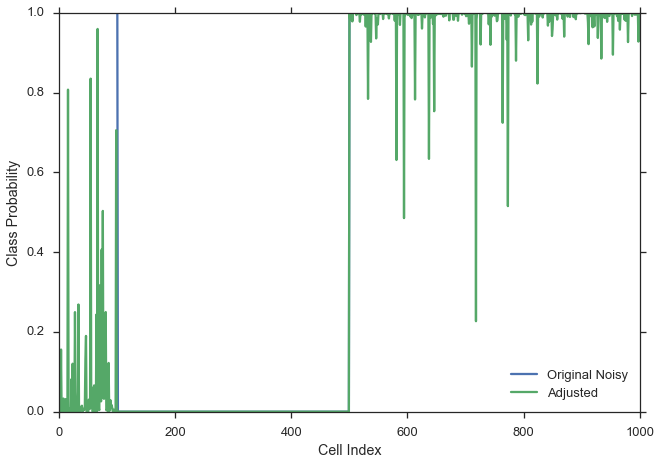

In [77]:
#Fit regression model on noisy covariates (note how the first ten percent of cells are reclassified as class 0)
lm_noise=sklearn.linear_model.Ridge()
lm_noise.fit(X_noise,Y)
B_noise=pd.DataFrame(lm_noise.coef_)
X_adjust_noise=bayes_cov_col(Y,X_noise,['class'],lm_noise)
plt.plot(X_noise,label='Original Noisy')
plt.plot(X_adjust_noise,label='Adjusted')
plt.legend(loc='lower right')
plt.xlabel('Cell Index')
plt.ylabel('Class Probability')

In [80]:
lm_noise_adjust=sklearn.linear_model.Ridge()
lm_noise_adjust.fit(X_adjust_noise,Y)
B_noise_adjust=pd.DataFrame(lm_noise_adjust.coef_)


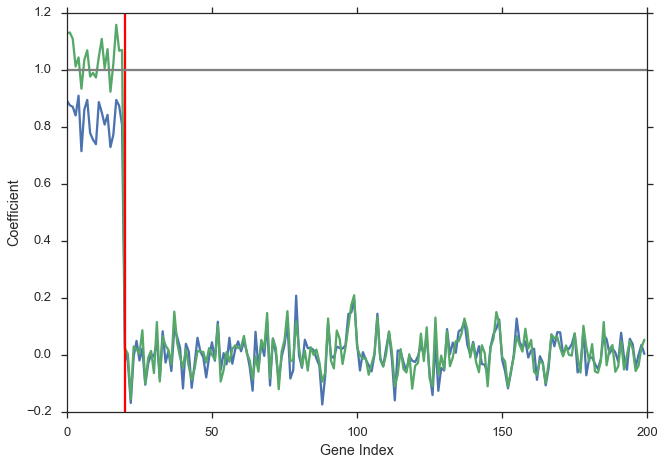

In [83]:
#coefficients for informative subset of genes
plt.plot(B_noise[0],label='Original')
plt.plot(B_noise_adjust[0],label='Adjusted')
plt.axvline(ngenes*informativegenes,c='red')
plt.axhline(effectsize,c='gray')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient')